In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

In [3]:
train.shape

(517754, 13)

In [4]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


### Is there any missing values in train and test dataset?

In [5]:
train.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [6]:
test.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [8]:
train['holiday'].value_counts()

holiday
True     260688
False    257066
Name: count, dtype: int64

### Using <code> LabelEncoder()</code> to convert categorical columns into numerical columns for predictive modeling

In [9]:
cat_cols = train.select_dtypes(include='object').columns.to_list()
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

train.head()
    

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,2,2,0.06,35,0,2,False,True,0,False,True,1,0.13
1,2,4,0.99,35,0,0,True,False,1,True,True,0,0.35
2,1,4,0.63,70,1,0,False,True,2,True,False,2,0.30
3,0,4,0.07,35,1,2,True,True,2,False,False,1,0.21
4,1,1,0.58,60,0,1,False,False,1,True,False,1,0.56


### Displaying the accident risk values to see whether they are normally distributed

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Accident risk')

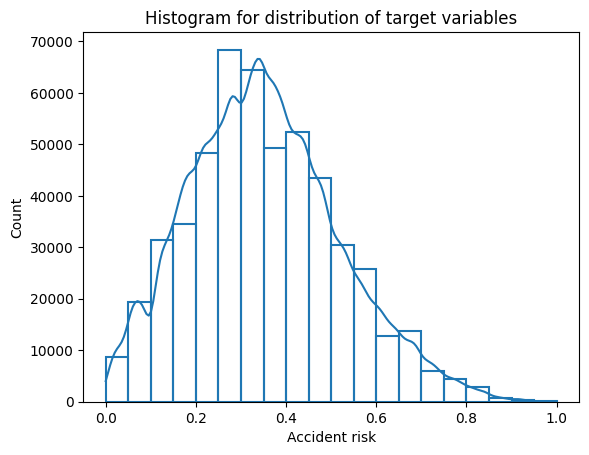

In [10]:
sns.histplot(x='accident_risk', bins=20, kde=True, data=train, fill=False)
plt.title('Histogram for distribution of target variables')
plt.xlabel('Accident risk')

#### We can view from the histplot that the plot is right-skewed distribution because of extreme higher values.

## Correlation Matrix

<Axes: >

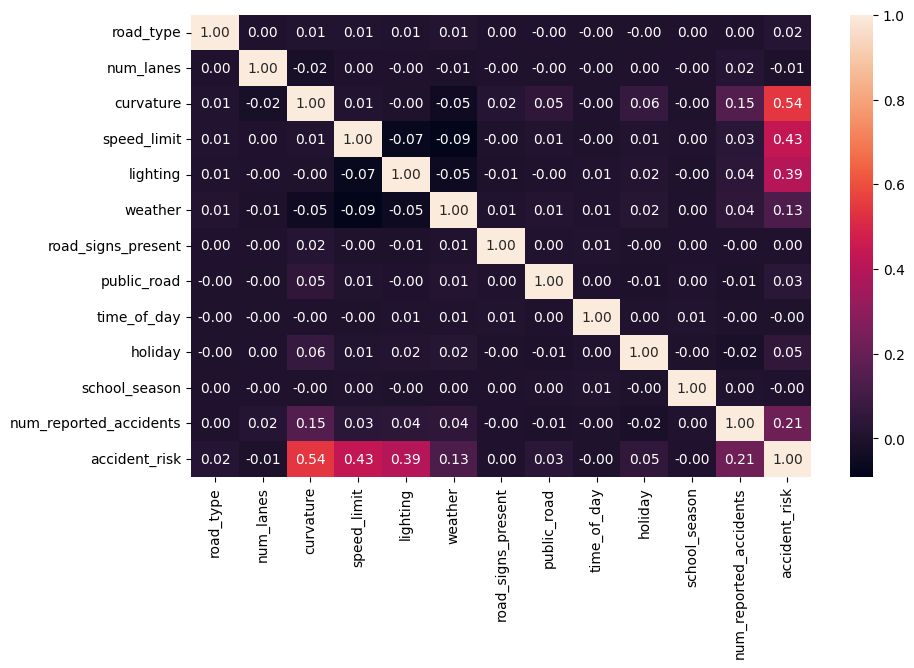

In [11]:
corr_values = train.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_values, annot=True, fmt='.2f')

### Correlation matrix shows that there are three features: curvature, speed_limit, and lighting are correlated with accident risk.

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
road_type,517754.0,0.995540,0.816326,0.0,0.00,1.00,2.00,2.0
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
lighting,517754.0,0.957312,0.801956,0.0,0.00,1.00,2.00,2.0
weather,517754.0,0.956889,0.804774,0.0,0.00,1.00,2.00,2.0
time_of_day,517754.0,1.003675,0.816191,0.0,0.00,1.00,2.00,2.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


In [13]:
train.shape

(517754, 13)

In [14]:
X = train.copy()
y = X.pop('accident_risk')

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2)

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred = lr.predict(X_valid)

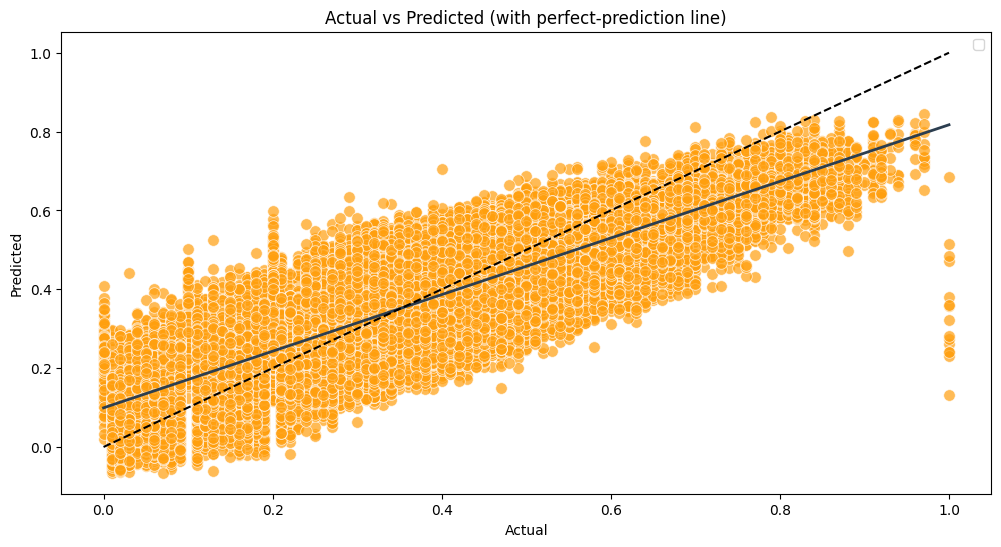

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot(
    x=y_valid, y=y_pred, color='#ff9f0ed2',
    scatter_kws={
        's': 70,           
        'alpha': 0.7,       
        'edgecolor': 'w',   
        'linewidth': 0.6
    },
    line_kws={'color': '#2c3e50', 'linewidth': 2},
    ci=95
)
ax.set_aspect('auto')
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--')
ax.set_title("Actual vs Predicted (with perfect-prediction line)")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.legend()

plt.show()

### Key observation:
- There is a strong linear relationship between actual and predicted values.
- The regression line(solid line) is below the perfect line(dashed line) for much of the range, indicating that the model underpredicts higher actual values.
- We can see that there are outliers near Actual ≈ 1.0 as vertical stacks of points.
- Consistent prediction can benefit from non-linear transformation such as polynomial or tree-based models.


In [19]:
def regression_results(y_true, y_pred, regr_type):

    # Regression metrics
    ev = explained_variance_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    
    print('Evaluation metrics for ' + regr_type + ' Linear Regression')
    print('Explained_variance: ',  round(ev,4)) 
    print('R2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print()

regression_results(y_valid, y_pred, 'LinearRegression')

Evaluation metrics for LinearRegression Linear Regression
Explained_variance:  0.7171
R2:  0.7171
MAE:  0.0708
MSE:  0.0078
RMSE:  0.0884



Mean residual (bias) = 0.0001
RMSE = 0.0884


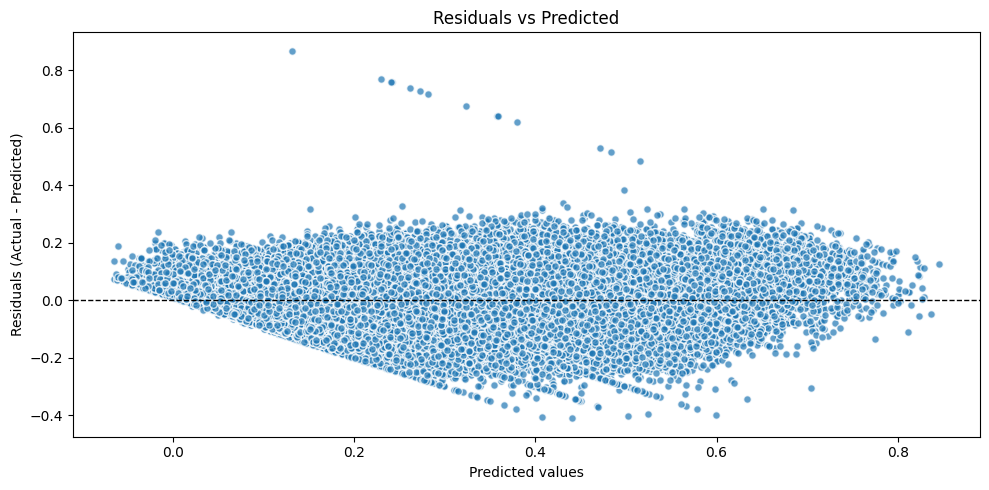

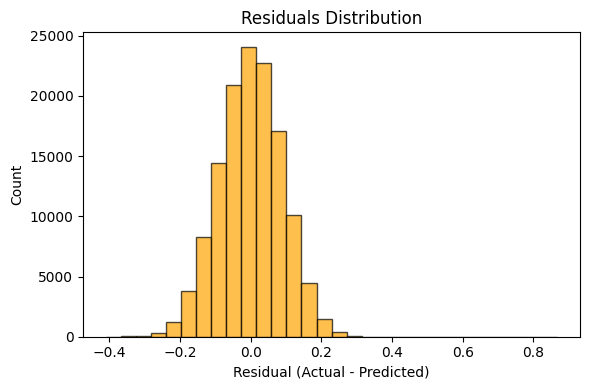

In [20]:
residuals = np.array(y_valid) - np.array(y_pred)

mean_resid = residuals.mean()
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f"Mean residual (bias) = {mean_resid:.4f}")
print(f"RMSE = {rmse:.4f}")

plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, s=30, alpha=0.7, edgecolor='w')
plt.axhline(0, color='black', linestyle='--', linewidth=1) 
plt.xlabel('Predicted values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k', color='orange', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()


* There are few points above 0.8 indicating cases where the model made large errors.
* These plots confirms that target variables needs to be transformed using log or sqrt function.

In [21]:
X_test = test.copy()
final_preds = lr.predict(X_test)

In [22]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub['accident_risk'] = final_preds
sub.to_csv('submission.csv', index=False)

In [23]:
sub.head()

,id,accident_risk
0,517754,0.345013
1,517755,0.185451
2,517756,0.288231
3,517757,0.425261
4,517758,0.319479
